# === 1. Thiết lập môi trường và import thư viện ===

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, utils, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, Activation
)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# === 2. Tải và chuẩn bị dữ liệu MNIST ===

- MNIST gồm 60k ảnh train và 10k ảnh test kích thước 28x28 grayscale.
- Ta sẽ reshape về (28,28,1) để tương thích Conv2D.

In [ ]:
# Load dữ liệu
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Hiển thị kích thước
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)


In [ ]:
# Chuẩn hóa (normalize) và reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
# Thêm chiều channel
X_train = np.expand_dims(X_train, axis=-1)  # (60000, 28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)    # (10000, 28, 28, 1)

In [ ]:
# Chuyển labels sang one-hot
num_classes = 10
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

In [ ]:
print("After reshape:", X_train.shape, y_train_cat.shape)

After reshape: (60000, 28, 28, 1) (60000, 10)


### Hiển thị một vài ảnh mẫu

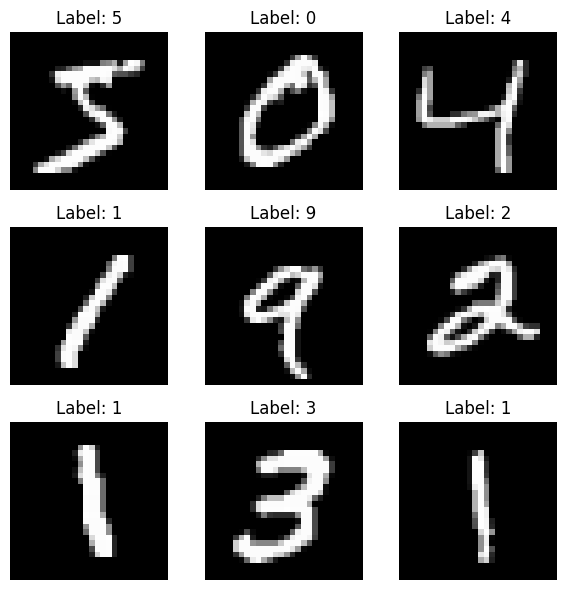

In [ ]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()

# === 3. Minh họa từng lớp cơ bản của CNN ===


## 3.1 Conv2D (lớp tích chập)


In [ ]:
# Tạo 1 layer Conv2D
conv = Conv2D(filters=2, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')

In [ ]:
# Để chạy layer độc lập, ta cần bọc vào một Model tạm
inp = Input(shape=(28,28,1))
out = conv(inp)
conv_model = Model(inputs=inp, outputs=out)

In [ ]:
# Chạy forward pass lấy output shape và giá trị feature maps
sample = X_train[:1]  # lấy 1 ảnh
feature_maps = conv_model.predict(sample)
print('Conv2D output shape:', feature_maps.shape)  # (1, 28, 28, 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Conv2D output shape: (1, 28, 28, 2)


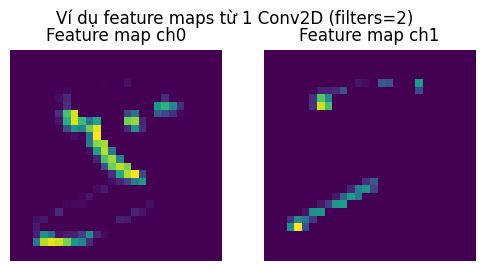

In [ ]:
# Vẽ các feature map (2 channels)
plt.figure(figsize=(6,3))
for i in range(feature_maps.shape[-1]):
    plt.subplot(1, feature_maps.shape[-1], i+1)
    plt.imshow(feature_maps[0,:,:,i], cmap='viridis')
    plt.title(f'Feature map ch{i}')
    plt.axis('off')
plt.suptitle('Ví dụ feature maps từ 1 Conv2D (filters=2)')
plt.show()

## 3.2 Stride và Padding
Thay đổi stride và padding sẽ thay đổi kích thước output.

In [ ]:
conv_stride = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), padding='valid')
model_stride = Model(inputs=inp, outputs=conv_stride(inp))
print('Stride=2, padding=valid -> output shape:', model_stride.predict(sample).shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Stride=2, padding=valid -> output shape: (1, 13, 13, 1)


In [ ]:
conv_same = Conv2D(filters=1, kernel_size=(3,3), strides=(2,2), padding='same')
model_same = Model(inputs=inp, outputs=conv_same(inp))
print('Stride=2, padding=same -> output shape:', model_same.predict(sample).shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Stride=2, padding=same -> output shape: (1, 14, 14, 1)


# 3.3 Pooling (MaxPooling2D, AveragePooling2D)
Pooling giảm kích thước không gian (height x width) của feature maps.

In [ ]:
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D

mp = MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')
mp_out = mp(feature_maps)
print('MaxPooling2D output shape:', mp_out.shape)

MaxPooling2D output shape: (1, 14, 14, 2)


In [ ]:
ap = AveragePooling2D(pool_size=(2,2), strides=2, padding='valid')
ap_out = ap(feature_maps)
print('AveragePooling2D output shape:', ap_out.shape)

AveragePooling2D output shape: (1, 14, 14, 2)


## 3.4 Flatten (làm phẳng)
Chuyển ma trận 3D thành vector 1D để đưa vào lớp Dense (FC)

In [ ]:
from tensorflow.keras.layers import Flatten
f = Flatten()
flat_out = f(mp_out)
print('Flatten output shape:', flat_out.shape)

Flatten output shape: (1, 392)


## 3.5 Dense (Fully connected)
 Lớp kết nối đầy đủ dùng để tổng hợp đặc trưng và phân loại.

In [ ]:
d = Dense(10, activation='softmax')
d_out = d(flat_out)
print('Dense output shape (softmax 10 classes):', d_out.shape)

Dense output shape (softmax 10 classes): (1, 10)


# 3.6 Activation, Dropout, BatchNormalization
* Activation: ReLU, Sigmoid, Tanh, Softmax.
* Dropout: kỹ thuật chống overfitting. (thường dùng p=0.2-0.5)
* BatchNormalization: chuẩn hóa output của lớp trước, giúp ổn định huấn luyện.

In [ ]:
from tensorflow.keras.layers import Dropout
bn = BatchNormalization()

# Áp dụng BatchNorm trên feature map tạm
bn_out = bn(feature_maps, training=False)
print('BatchNormalization keeps same shape:', bn_out.shape)

BatchNormalization keeps same shape: (1, 28, 28, 2)


In [ ]:
drop = Dropout(rate=0.5)
drop_out = drop(flat_out, training=False)  # training=False -> dropout không active
print('Dropout (inference mode) keeps shape:', drop_out.shape)

Dropout (inference mode) keeps shape: (1, 392)


# === 4. Xây dựng mô hình CNN mẫu ===


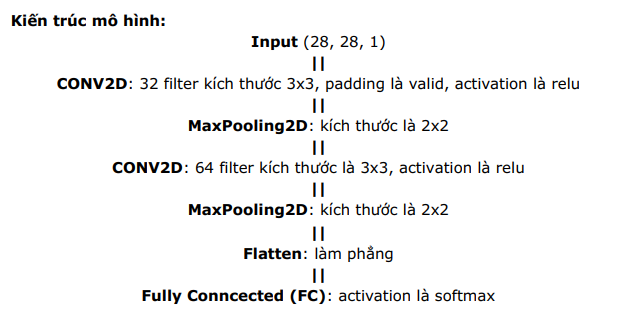

In [ ]:
model = Sequential([
    # Input(shape=(28,28,1))
    # - Định nghĩa shape của input cho model: chiều cao 28, chiều rộng 28, 1 channel (grayscale).
    Input(shape=(28,28,1)),

    # Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')
    # - Lớp tích chập 2D với 32 filter (output channels = 32).
    # - kernel_size=(3,3) nghĩa là mỗi filter có kích thước 3x3.
    # - padding='valid' (không padding) sẽ làm giảm kích thước spatial (H,W) sau tích chập.
    # - activation='relu' áp dụng hàm kích hoạt ReLU cho output của lớp này.
    Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'),

    # MaxPooling2D(pool_size=(2,2))
    # - Lớp pooling lấy giá trị lớn nhất trong mỗi khung 2x2 (giảm kích thước không gian xuống còn 1/2).
    # - Thường dùng sau Conv để giảm dimension và giữ đặc trưng quan trọng.
    MaxPooling2D(pool_size=(2,2)),

    # Conv2D(64, kernel_size=(3,3), activation='relu')
    # - Lớp tích chập thứ hai tăng số filter lên 64 (tập các đặc trưng trừu tượng hơn).
    # - Mặc định padding='valid' nếu không khai báo.
    Conv2D(64, kernel_size=(3,3), activation='relu'),

    # MaxPooling2D(pool_size=(2,2))
    # - Lại làm giảm kích thước feature maps.
    MaxPooling2D(pool_size=(2,2)),

    # Flatten()
    # - Chuyển tensor 3D (H, W, channels) thành vector 1D để đưa vào Dense layers.
    Flatten(),

    # Dense(10, activation='softmax')
    # - Lớp fully-connected cuối cùng (output layer) với 10 units tương ứng 10 lớp phân loại MNIST.
    # - activation='softmax' đưa ra phân phối xác suất trên 10 lớp (tổng = 1).
    Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

### Compile và huấn luyện
* Loss: CategoricalCrossentropy
* Optimizer: Adam (learning_rate=0.01 theo file tham khảo; tuy nhiên mức lr này khá cao, có thể giảm xuống 0.001)
* Metrics: accuracy

In [ ]:
# optimizer = optimizers.Adam(learning_rate=0.01)
# - Adam optimizer: thuật toán tối ưu phổ biến; learning_rate=0.01
#   (lưu ý: lr = 0.01 khá cao; thường dùng 0.001 hoặc 5e-4)
optimizer = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Tách validation từ tập train
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.1, random_state=42)

In [ ]:
history = model.fit(X_tr, y_tr, batch_size=128, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.8902 - loss: 0.3495 - val_accuracy: 0.9827 - val_loss: 0.0553
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9861 - loss: 0.0470 - val_accuracy: 0.9870 - val_loss: 0.0470
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9897 - loss: 0.0338 - val_accuracy: 0.9857 - val_loss: 0.0562
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.9915 - loss: 0.0279 - val_accuracy: 0.9867 - val_loss: 0.0509
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9914 - loss: 0.0275 - val_accuracy: 0.9860 - val_loss: 0.0551


### Plot kết quả (accuracy và loss)

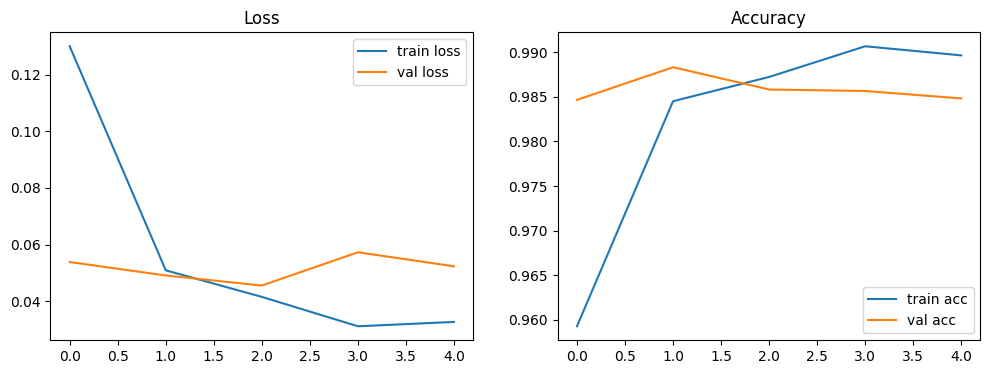

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

### Đánh giá trên tập test

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

Test accuracy: 0.9854, Test loss: 0.0512


### Kiểm tra tổng xác suất của lớp Softmax
Với một ảnh bất kỳ, tổng các xác suất từ softmax phải xấp xỉ 1.

In [ ]:
sample_pred = model.predict(X_test[:3])
print('Softmax sums (per example):', np.sum(sample_pred, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Softmax sums (per example): [1.         1.         0.99999994]


# === 5. Minh họa LeNet-5 ===
LeNet-5: một kiến trúc CNN cổ điển, phù hợp với MNIST.

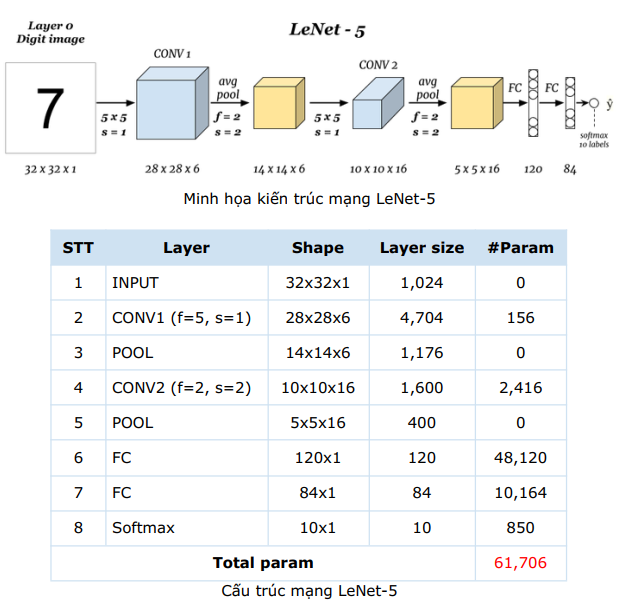

In [ ]:
lenet = Sequential([
    # Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1))
    # - Lớp conv đầu LeNet với 6 filter 5x5; padding='same' giữ nguyên H,W
    Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)),

    # AveragePooling2D(pool_size=(2,2), strides=2)
    # - Trung bình hóa trong ô 2x2 và giảm kích thước (giống pooling nhưng lấy mean)
    AveragePooling2D(pool_size=(2,2), strides=2),

    # Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu')
    Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='relu'),
    AveragePooling2D(pool_size=(2,2), strides=2),

    # Flatten -> Dense(120) -> Dense(84) -> Dense(10)
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
lenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lenet.compile(optimizer=optimizers.Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Inception Block

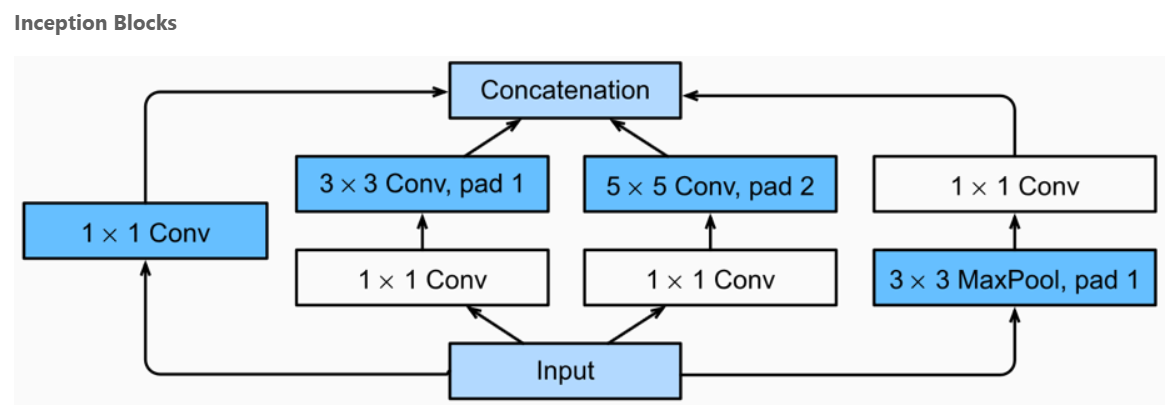

In [ ]:
# === Inception Block cơ bản ===
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input
from tensorflow.keras.models import Model

def inception_block(x, filters):
    """
    x: đầu vào (tensor)
    filters: tuple gồm (f1, f3r, f3, f5r, f5, fp)
        - f1: số filters của nhánh 1x1
        - f3r, f3: filters của nhánh 1x1 -> 3x3
        - f5r, f5: filters của nhánh 1x1 -> 5x5
        - fp: filters của nhánh pooling -> 1x1
    """
    f1, f3r, f3, f5r, f5, fp = filters

    # Nhánh 1: Conv 1x1
    branch1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)

    # Nhánh 2: 1x1 -> 3x3
    branch2 = Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    branch2 = Conv2D(f3, (3,3), padding='same', activation='relu')(branch2)

    # Nhánh 3: 1x1 -> 5x5
    branch3 = Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    branch3 = Conv2D(f5, (5,5), padding='same', activation='relu')(branch3)

    # Nhánh 4: MaxPooling -> 1x1
    branch4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    branch4 = Conv2D(fp, (1,1), padding='same', activation='relu')(branch4)

    # Gộp 4 nhánh lại
    output = concatenate([branch1, branch2, branch3, branch4], axis=-1)
    return output

# === Demo GoogLeNet mini ===
inp = Input(shape=(28,28,1))
x = inception_block(inp, (16, 16, 24, 4, 8, 8))
x = MaxPooling2D((2,2))(x)
x = inception_block(x, (32, 32, 48, 8, 16, 16))
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(10, activation='softmax')(x)

inception_model = Model(inputs=inp, outputs=out)
inception_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │         32 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28, 4) │          8 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28, 1) │          0 │ input_layer_3[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │         32 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │      3,480 │ conv2d_8[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 28, 28, 8) │        808 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28, 8) │         16 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_7[0][0],   │
│ (Concatenate)       │ 56)               │            │ conv2d_9[0][0],   │
│                     │                   │            │ conv2d_11[0][0],  │
│                     │                   │            │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 14, 14,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 14, 14,    │      1,824 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 14, 14, 8) │        456 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 14,    │          0 │ max_pooling2d_4[… │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 14, 14,    │      1,824 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 14, 14,    │     13,872 │ conv2d_14[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 14, 14,    │      3,216 │ conv2d_16[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 14, 14,    │        912 │ max_pooling2d_5[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 378,426 (1.44 MB)

 Trainable params: 378,426 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

# Residual Block

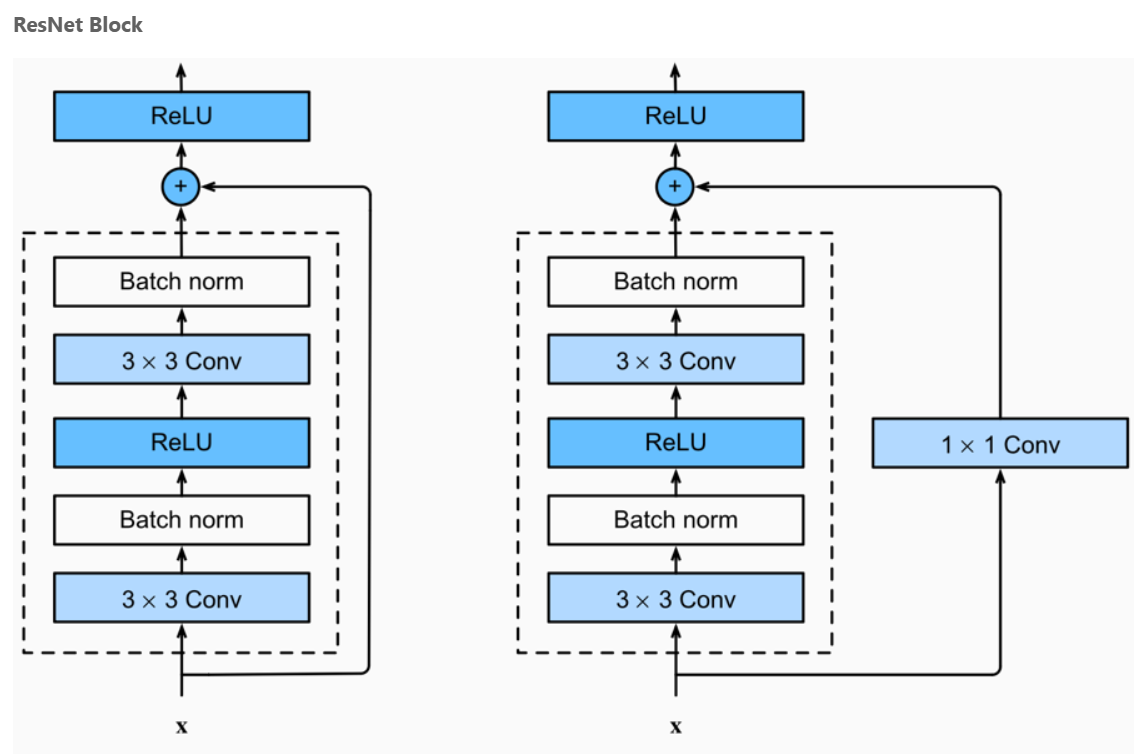

In [ ]:
# === Residual Block cơ bản (ResNet-style) ===
from tensorflow.keras.layers import Add, Activation, BatchNormalization

def residual_block(x, filters, stride=1):
    """
    x: đầu vào
    filters: số filter của conv layers
    stride: bước stride cho conv đầu tiên
    """
    shortcut = x  # lưu lại input để cộng skip

    # Nhánh chính
    x = Conv2D(filters, (3,3), strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Nếu kích thước thay đổi (do stride>1), dùng 1x1 conv để điều chỉnh shortcut
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Cộng skip connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# === Demo ResNet mini (trên MNIST) ===
inp = Input(shape=(28,28,1))
x = Conv2D(32, (3,3), padding='same', activation='relu')(inp)
x = residual_block(x, 32)
x = residual_block(x, 32)
x = MaxPooling2D((2,2))(x)
x = residual_block(x, 64, stride=2)
x = residual_block(x, 64)
x = GlobalAveragePooling2D()(x)
out = Dense(10, activation='softmax')(x)

resnet_model = Model(inputs=inp, outputs=out)
resnet_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 28, 28,    │      9,248 │ conv2d_39[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 28, 28,    │      9,248 │ activation_16[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 28, 28,    │          0 │ add_8[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 28, 28,    │      9,248 │ activation_17[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 28, 28,    │      9,248 │ activation_18[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 28, 28,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 14, 14,    │          0 │ activation_19[0]

 Total params: 171,146 (668.54 KB)

 Trainable params: 170,250 (665.04 KB)

 Non-trainable params: 896 (3.50 KB)